In [ ]:
import numpy as np
import time
!pip3 install pyro-ppl
import pyro
import pyro.distributions as dists
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.nn import PyroParam
import torchvision.transforms as transforms
from pyro.contrib.examples.util import MNIST

import torch
import torch.nn as nn
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro import poutine

from sklearn import datasets


In [ ]:
colors = ["navy", "turquoise", "darkorange"]
iris = datasets.load_iris()
iris.data = iris.data.astype(np.float32)
n_classes = len(np.unique(iris.target))
print(iris.data)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [ ]:
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith('1.8.0')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

data = torch.utils.data.DataLoader(dataset = iris.data, batch_size = 30, shuffle = True)

TypeError: ignored

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 4)
        self.softplus = nn.Softplus()
        self.maxpooling = nn.AdaptiveMaxPool1d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        # loc_img = self.maxpooling(self.fc21(hidden).unsqueeze(0).permute(0, 2, 1)).squeeze(0).squeeze(1)
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(4, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()

    def forward(self, x):

        # x = x.reshape(-1, 4)
 
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [ ]:
class VAE(nn.Module):
    def __init__(self, z_dim=4, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        weights = pyro.sample("weights", dists.Dirichlet(torch.ones(3) / 3))
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.tensor(np.random.randn(x.shape[0], self.z_dim))
            z_scale = torch.tensor(np.random.randn(x.shape[0], self.z_dim))
            assignment = pyro.sample("assignment", dists.Categorical(weights))

        locs = []
        scales = []

        for i in range(3):
          locs.append(torch.mean(z_loc[assignment == i], dim = 0))
          scales.append(torch.var(z_loc[assignment == i],axis = 0))

        locs = torch.stack(locs)
        scales = torch.stack(scales)

        with pyro.iarange("datas", x.shape[0]) as i:
            pyro.sample("obs",dist.Normal(locs[assignment[i]], scales[assignment[i]]).to_event(1), obs=x.reshape(-1, 4))
            
        print("weights {}".format(weights))
        print("locs {}".format(locs))
        print("scales {}".format(scales))

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        # weights_posterior = pyro.param("weights_posterior", dist.Dirichlet(torch.ones(3)), constraint = dists.constraints.unit_interval)
        weights = pyro.sample("weights", dists.Dirichlet(torch.ones(3)))
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            # pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            assignment = pyro.sample("assignment", dists.Categorical(weights))
        
        locs = []
        scales = []

        for i in range(3):
          locs.append(torch.mean(z_loc[assignment == i], dim = 0))
          scales.append(torch.var(z_loc[assignment == i],axis = 0, unbiased = False))

        locs = torch.stack(locs)
        scales = torch.stack(scales)


In [ ]:
pyro.clear_param_store()
vae = VAE()
optimizer = Adam({"lr": 1.0e-3, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_iarange_nesting=1)
svi = SVI(vae.model, vae.guide, optimizer, loss = elbo)

n_steps = 2501
start = time.time()
elbos = []
for i in range(n_steps):
  print(i)
  elbo = 0
  for x in data:
        elbo += svi.step(x)
  elbos.append(elbo/len(data.dataset))


0


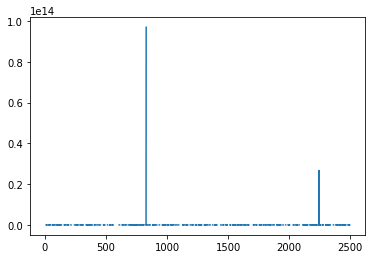

In [ ]:
elbos
elbos1 = elbos
print(np.argmax(elbos))
import matplotlib.pyplot as plt
plt.figure()
plt.plot(elbos)